<a href="https://colab.research.google.com/github/Graylab/DL4Proteins-notebooks/blob/main/notebooks/WS05_LanguageModelEmbeddingsTransferLearningForDownstreamTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color='#569098' size=20>Language Model Embeddings Transfer Learning for Downstream Task</font>**

##[Return to HomePage](https://github.com/Graylab/DL4Proteins-notebooks)

Code and tutorial adapted from Sergey Ovchinnikov's talk and [notebook](https://colab.research.google.com/github/sokrypton/roscon2024/blob/main/finetune_esm2.ipynb) from RosettaCon 2024

**OBJECTIVES: By the end of this workshop you should be able to:**
* <font color='#e59454'>Explain the benefits of finetuning pre-trained protein language models</font>
* <font color='#e59454'>Finetune a model using LoRA (Low Rank Adaptation)</font>
* <font color='#e59454'>Apply finetuning to a practical task: predicting ligand-binding sites</font>

**_To save your work, please save a copy of this notebook into your  personal google drive._**

## **<font color='#569098' size = 5>Table of Contents:**

#### **[Section 1: Introduction to protein language models](https://colab.research.google.com/drive/1u8OhKlsm_pcuB2vYWSR8JXQELY0YfDgq#scrollTo=-11Vix19zlyJ)**
* [Introduction: Why finetune?](https://colab.research.google.com/drive/1u8OhKlsm_pcuB2vYWSR8JXQELY0YfDgq#scrollTo=-11Vix19zlyJ)

#### **[Section 2: Direct Finetuning ESM](https://colab.research.google.com/drive/1u8OhKlsm_pcuB2vYWSR8JXQELY0YfDgq#scrollTo=SgNiijAzzlyL)**
* [Direct Finetuning: Visualizing ESM](https://colab.research.google.com/drive/1u8OhKlsm_pcuB2vYWSR8JXQELY0YfDgq#scrollTo=t_0WYotopJE6)
* [Direct Finetuning: Training](https://colab.research.google.com/drive/1u8OhKlsm_pcuB2vYWSR8JXQELY0YfDgq#scrollTo=q1xg8blxzlyL)

#### **[Section 3: Low-Rank Adaptor Finetuning ESM](https://colab.research.google.com/drive/1u8OhKlsm_pcuB2vYWSR8JXQELY0YfDgq#scrollTo=0oo3HdqUzlyL)**
* [LoRA: Attaching LoRA to ESM](https://colab.research.google.com/drive/1u8OhKlsm_pcuB2vYWSR8JXQELY0YfDgq#scrollTo=VRxQNb1WzlyM&line=1&uniqifier=1)
* [LoRA: What is LoRA?](https://colab.research.google.com/drive/1u8OhKlsm_pcuB2vYWSR8JXQELY0YfDgq#scrollTo=83TEKjw9ted-)
* [LoRA: Training with LoRA](https://colab.research.google.com/drive/1u8OhKlsm_pcuB2vYWSR8JXQELY0YfDgq#scrollTo=ESNXggJVtZre)


# **<font color='#569098'>Section 1: Introduction to Protein Language Models**</font>


Github test

Protein language models, trained on large datasets of protein sequences, have revolutionized our ability to understand and predict protein structures and functions. While these pre-trained models capture general patterns in protein sequences, they often need to be adapted for specific tasks. This process is called finetuning.

## **<font color='#569098'>Why Finetune?**</font>
1. <font color='#e59454'>Task Specificity:</font> Pre-trained models provide a general understanding of protein sequences, but specific tasks may require more focused knowledge.
2. <font color='#e59454'>Limited Data: </font>Many protein-related tasks have limited labeled data. Finetuning allows leveraging the pre-trained model's knowledge while adapting to the specific task.
3. <font color='#e59454'>Efficiency:</font> Starting from a pre-trained model is often faster and more effective than training from scratch.

However, finetuning comes with its own challenges.
Finetuning all parameters of a large model can be computationally expensive, and we are still limited by our dataset size. With limited task-specific data, full finetuning may lead to overfitting and the model may lose its general knowledge while adapting to a specific task.


In [ ]:
#@markdown <font color='#e59454'>Question Time! Run to Show Question
from IPython.display import HTML, display
from ipywidgets import widgets

def create_answer_box(question, correct_answer):
    def display_answer(button):
        user_answer = text_area.value.strip()
        result.value = f"<pre class='answer-text'><b>{correct_answer}</b></pre>"

    text_area = widgets.Textarea(
        placeholder='Enter your answer here...',
        layout={'width': '95%', 'height': '100px'}
    )
    submit_button = widgets.Button(description="Submit")
    result = widgets.HTML(value="")

    vbox = widgets.VBox([text_area, submit_button, result])
    submit_button.on_click(display_answer)

    display(HTML(f"<b>{question}</b>"))
    display(vbox)
    display(HTML("""
    <style>
    .widget-html-content {
        width: 95%;
        white-space: normal;
        word-wrap: break-word;
    }
    .answer-text {
        width: 90%;
        color: green;
        line-height: 1.5;
        white-space: pre-wrap;
        word-wrap: break-word;
        font-family: inherit;
        font-size: inherit;
        margin: 0;
        padding: 0;
    }
    </style>
    """))

# Example usage
create_answer_box('What might be an example where finetuning is useful',
                  'Any application with limited data would benefit from finetuning, as it allows us to use transfer learning from more general data.')

# **<font color='#569098'>Section 2: Direct Finetuning ESM**</font>

One important application of finetuning is predicting which positions in a protein could interact with a ligand. This information is crucial for understanding protein function and designing new drugs.

For this particular task, we are using ESM embeddings to determine the probability of whether each residue binds a ligand or not. We simply tune ESM on a set of proteins with labelled binding pockets.



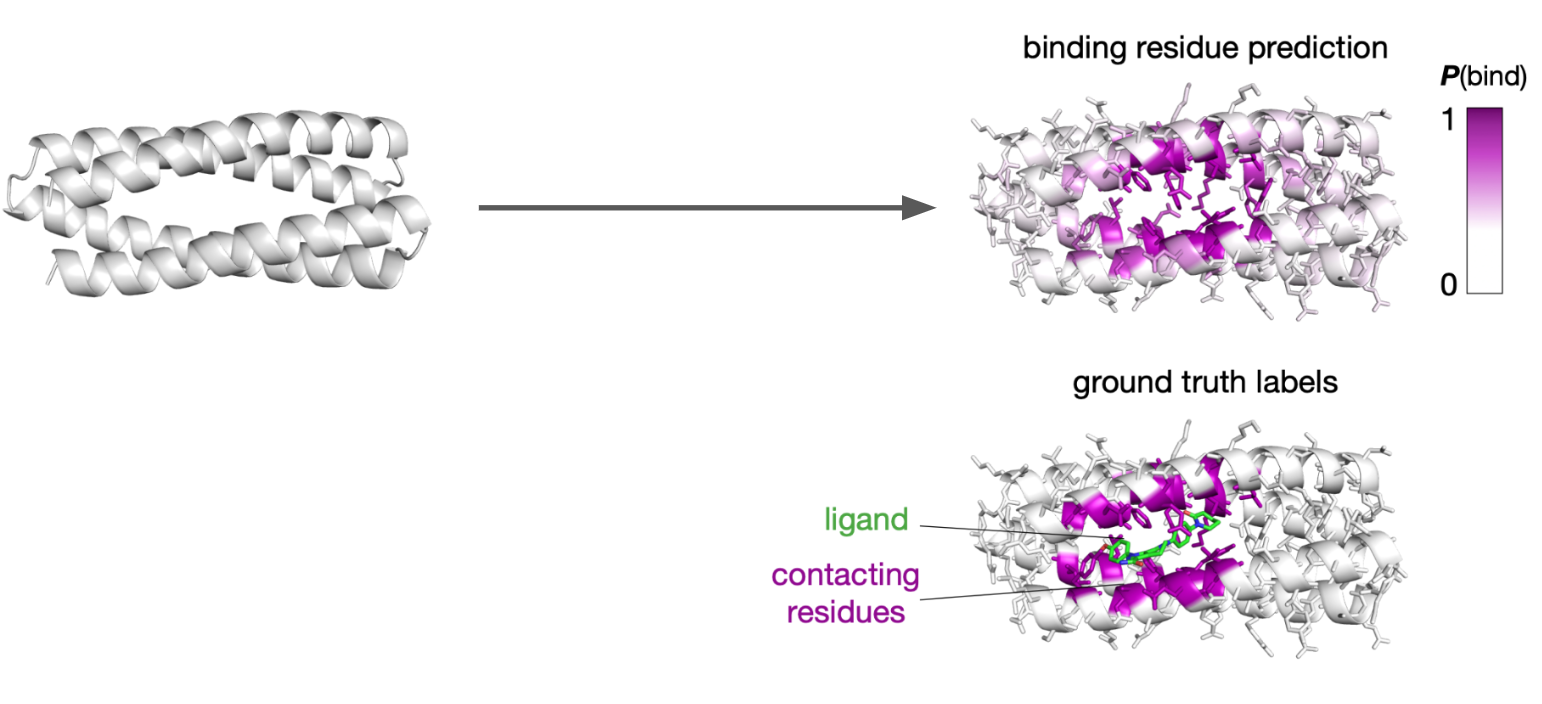

In [ ]:
#@markdown Let's set up our environment and load the necessary libraries. Take a peak at the code if you are interested in learning how to import large language models using the HuggingFace transformers library!
model_name = "esm2_t6_8M_UR50D" # @param ["esm2_t33_650M_UR50D", "esm2_t30_150M_UR50D", "esm2_t12_35M_UR50D", "esm2_t6_8M_UR50D"]
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import EsmForSequenceClassification, EsmForTokenClassification, AutoTokenizer

trainable_params = lambda x: sum(p.numel() for p in x.parameters() if p.requires_grad)


DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = EsmForTokenClassification.from_pretrained(f"facebook/{model_name}",
                                                  num_labels=1,
                                                  hidden_dropout_prob=0.15)

tokenizer = AutoTokenizer.from_pretrained(f"facebook/{model_name}")
model = model.to(DEVICE)

Some weights of EsmForTokenClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#@markdown Let's take a look at our model and how many parameters we are training
print(f'NUMBER OF TRAINABLE PARAMETERS: {trainable_params(model)}')
print('\nModel Information\n----------------------------')
model

NUMBER OF TRAINABLE PARAMETERS: 7737722

Model Information
----------------------------


EsmForTokenClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.15, inplace=False)
      (position_embeddings): Embedding(1026, 320, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.15, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05, 

## **<font color='#569098'>Raw Fine-Tuning**</font>
Here, we have imported a large language model (ESM2) and added extra layers to tune it for predicting ligand contacts. Let's test out a naive approach by just directly finetuning all of the parameters in our protein language model. As the model trains, think about this method's limitations.





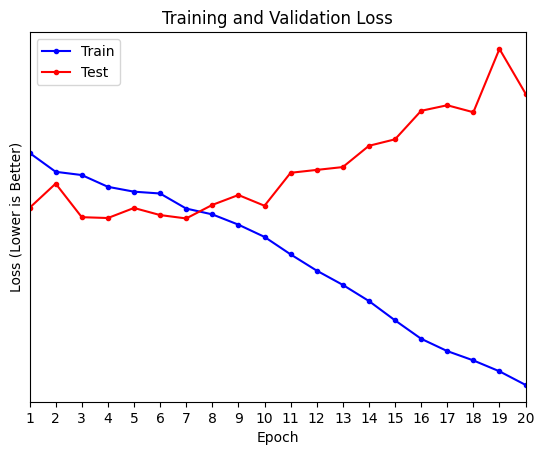

Training complete.


In [ ]:
%matplotlib inline
from IPython.display import display, clear_output
#@markdown Run training!!!

# GET DATA
batch_size = 32
max_crop_len = 512

!wget -qnc https://github.com/sokrypton/roscon2024/raw/main/af2bind_data_0.pkl
import pickle
with open("af2bind_data_0.pkl", "rb") as handle:
  DATA = pickle.load(handle)

import numpy as np
import pickle
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Helper function to pad sequences
def pad_sequence(seq, max_len, pad_value=0):
    pad_size = max(0, max_len - len(seq))
    return np.pad(seq, (0, pad_size), 'constant', constant_values=pad_value)[:max_len]

class CustomProteinDataset(Dataset):
    def __init__(self, inputs, attention_masks, outputs, masks, max_crop_len=128):
        self.inputs = inputs
        self.attention_masks = attention_masks
        self.outputs = outputs
        self.masks = masks
        self.max_crop_len = max_crop_len

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_ids = self.inputs[idx]
        attention_mask = self.attention_masks[idx]
        output = self.outputs[idx]
        mask = self.masks[idx]

        # Calculate the true length of the sequence (where attention_mask == 1)
        true_len = int(np.sum(attention_mask))

        # Determine the crop length (if the true length is less than max_crop_len, use true_len)
        crop_len = min(self.max_crop_len, true_len)

        # Randomly sample a crop starting index
        if true_len > crop_len:
            start_idx = np.random.randint(0, true_len - crop_len + 1)
        else:
            start_idx = 0

        # Crop the sequences
        input_ids = input_ids[start_idx:start_idx + crop_len]
        attention_mask = attention_mask[start_idx:start_idx + crop_len].astype(np.float32)
        output = output[start_idx:start_idx + crop_len].astype(np.float32)
        mask = mask[start_idx:start_idx + crop_len].astype(np.float32)

        # Pad the cropped sequences to max_crop_len
        input_ids = pad_sequence(input_ids, self.max_crop_len)
        attention_mask = pad_sequence(attention_mask, self.max_crop_len)
        output = pad_sequence(output, self.max_crop_len)
        mask = pad_sequence(mask, self.max_crop_len)

        return torch.tensor(input_ids), torch.tensor(attention_mask), torch.tensor(output), torch.tensor(mask)

# Create DataLoaders
dataloaders = []
for v in range(3):  # train/test/validation
    dataset = CustomProteinDataset(DATA["inputs"][v], DATA["attention_masks"][v],
                                   DATA["outputs"][v], DATA["masks"][v],
                                   max_crop_len=max_crop_len)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=(v == 0))
    dataloaders.append(dataloader)


# Training Code

def compute_loss(logits, labels, mask):
  """Compute masked loss."""
  loss = nn.BCEWithLogitsLoss(reduction='none')(logits, labels)
  masked_loss = loss * mask
  mean_loss = masked_loss.sum() / mask.sum()
  return mean_loss

def train_one_epoch(model, dataloader, optimizer):
  """Train the model for one epoch."""
  model.train()
  total_loss = 0

  for batch in dataloader:
    inputs_batch, attention_masks_batch, true_labels_batch, mask_batch = [x.to(DEVICE) for x in batch]

    # Forward pass
    outputs = model(input_ids=inputs_batch, attention_mask=attention_masks_batch)
    logits = outputs.logits.squeeze(-1)

    # Compute loss
    mean_loss = compute_loss(logits, true_labels_batch, mask_batch)

    # Backward pass and optimization
    optimizer.zero_grad()
    mean_loss.backward()
    optimizer.step()

    total_loss += mean_loss.item()

  average_loss = total_loss / len(dataloader)
  return average_loss

def validate(model, dataloader):
    """Validate the model."""
    model.eval()
    total_loss = 0

    with torch.no_grad():
      for batch in dataloader:
        inputs_batch, attention_masks_batch, true_labels_batch, mask_batch = [x.to(DEVICE) for x in batch]

        # Forward pass
        outputs = model(input_ids=inputs_batch, attention_mask=attention_masks_batch)
        logits = outputs.logits.squeeze(-1)

        # Compute loss
        mean_loss = compute_loss(logits, true_labels_batch, mask_batch)

        total_loss += mean_loss.item()

    average_loss = total_loss / len(dataloader)
    return average_loss



# Training loop
def train_model(model, train_dataloader, test_dataloader, num_epochs, optimizer):
    """Train and validate the model."""
    epoch_plot = []
    train_plot = []
    test_plot = []
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_dataloader, optimizer)
        test_loss = validate(model, test_dataloader)
        #print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        # clear matplotlib plot if already exists
        plt.clf()
        clear_output(wait=True)
        # visualize with matplotlib
        epoch_plot.append(epoch + 1)
        train_plot.append(train_loss)
        test_plot.append(test_loss)
        plt.plot(epoch_plot, train_plot, 'b.-', label='Train')
        plt.plot(epoch_plot, test_plot, 'r.-', label='Test')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (Lower is Better)')
        plt.title('Training and Validation Loss')
        # Set ticks
        plt.yticks([])
        plt.xlim(1, num_epochs)
        plt.xticks(range(1, num_epochs+1))
        plt.legend()
        plt.show()

    print("Training complete.")

# Actually run training
learning_rate = 1e-3 # @param {"type":"number"}
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20  # @param {"type":"integer"}
train_model(model, dataloaders[0], dataloaders[1], num_epochs, optimizer)

In [ ]:
#@markdown <font color='#e59454'>Question Time! Run to Show Question
from IPython.display import HTML, display
from ipywidgets import widgets

def create_answer_box(question, correct_answer):
    def display_answer(button):
        user_answer = text_area.value.strip()
        result.value = f"<pre class='answer-text'><b>{correct_answer}</b></pre>"

    text_area = widgets.Textarea(
        placeholder='Enter your answer here...',
        layout={'width': '95%', 'height': '100px'}
    )
    submit_button = widgets.Button(description="Submit")
    result = widgets.HTML(value="")

    vbox = widgets.VBox([text_area, submit_button, result])
    submit_button.on_click(display_answer)

    display(HTML(f"<b>{question}</b>"))
    display(vbox)
    display(HTML("""
    <style>
    .widget-html-content {
        width: 95%;
        white-space: normal;
        word-wrap: break-word;
    }
    .answer-text {
        width: 90%;
        color: green;
        line-height: 1.5;
        white-space: pre-wrap;
        word-wrap: break-word;
        font-family: inherit;
        font-size: inherit;
        margin: 0;
        padding: 0;
    }
    </style>
    """))

# Example usage
create_answer_box('Why might directly finetuning be suboptimal?',
                  '1. Training is slow since we need to train lots of parameters\n2. Direct finetuning leads to overfitting when working with smaller datasets.')

# **<font color='#569098'>Section 3: Low Rank Adaptor (LoRA) Finetuning ESM**</font>
LoRA is an efficient finetuning technique that addresses many challenges associated with finetuning large models. Let's set up our dependencies again. However, something is different when we take a look into the model and trainable parameters. Can you tell what happened?

In [ ]:
#@markdown Set up dependencies (Re-run for each time you run the training below)

# https://github.com/huggingface/peft
!pip -q install --no-dependencies peft
from peft import LoraConfig, get_peft_model, TaskType
model = EsmForTokenClassification.from_pretrained(f"facebook/{model_name}",
                                                  num_labels=1,
                                                  hidden_dropout_prob=0.15)

tokenizer = AutoTokenizer.from_pretrained(f"facebook/{model_name}")
model = model.to(DEVICE)

config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    target_modules=["query", "key", "value"],
    r=4,
    lora_dropout=0.15,
)
model = get_peft_model(model, config)

Some weights of EsmForTokenClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#@markdown Show trainable parameters and model
print(f'NUMBER OF TRAINABLE PARAMETERS: {trainable_params(model)}')
print('\nModel Information\n----------------------------')
model

NUMBER OF TRAINABLE PARAMETERS: 46401

Model Information
----------------------------


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): EsmForTokenClassification(
      (esm): EsmModel(
        (embeddings): EsmEmbeddings(
          (word_embeddings): Embedding(33, 320, padding_idx=1)
          (dropout): Dropout(p=0.15, inplace=False)
          (position_embeddings): Embedding(1026, 320, padding_idx=1)
        )
        (encoder): EsmEncoder(
          (layer): ModuleList(
            (0-5): 6 x EsmLayer(
              (attention): EsmAttention(
                (self): EsmSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=320, out_features=320, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.15, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=320, out_features=4, bias=False)
                    )
                    (lora_B): ModuleDict(
             

In [ ]:
#@markdown <font color='#e59454'>Question Time! Run to Show Question

import random
from IPython.display import display, HTML

def create_quiz(question, correct_answers, decoy_answers):
    # Combine the correct answers with the decoy answers
    answers = correct_answers + decoy_answers
    # Shuffle the answers
    random.shuffle(answers)

    # Generate the HTML code
    html_code = f""" <div style="font-family: Arial, sans-serif; margin: 30px; max-width: 1000px;">
    <h3 style="word-wrap: break-word;">{question}</h3>"""

    # Add each answer as a checkbox
    for i, answer in enumerate(answers):
        html_code += f"""
        <div style="word-wrap: break-word; margin-bottom: 10px;">
        <input type="checkbox" id="option{i}" name="quiz" value="{answer}">
        <label for="option{i}" id="label{i}">{answer}</label>
        </div>"""

    # Add the submit button and feedback section
    html_code += f"""
    <button onclick="checkAnswers()">Submit</button>
    <p id="feedback" style="font-weight: bold;"></p>
    </div>
    <script>
    function checkAnswers() {{
        var checkboxes = document.getElementsByName('quiz');
        var correctAnswers = {str(correct_answers)};
        var feedback = document.getElementById('feedback');
        var numCorrect = 0;

        // Check each answer
        for (var i = 0, length = checkboxes.length; i < length; i++) {{
            var checkbox = checkboxes[i];
            var label = document.getElementById('label' + i);

            if (correctAnswers.includes(checkbox.value)) {{
                if (checkbox.checked) {{
                  if (numCorrect >= 0) {{
                    numCorrect++;
                  }}
                    label.style.color = "green";
                }} else {{
                    //label.style.color = "red";
                }}
            }} else if (checkbox.checked) {{
                numCorrect = -9999;
                label.style.color = "red";
            }} else {{
                //label.style.color = "inherit";
            }}
        }}

        // Provide feedback
        if (numCorrect === {len(correct_answers)}) {{
            feedback.textContent = "Correct!";
            feedback.style.color = "green";
        }} else {{
            feedback.textContent = "Incorrect.";
            feedback.style.color = "red";
        }}
    }}
    </script>"""

    display(HTML(html_code))

# Example
question = "What is different? Select all the correct answers."
correct_answers = ["The model now has less trainable parameters", "The model has new connections at each layer", "The model has more parameters"]
decoy_answers = ["The model has become deeper (more layers)", "Nothing has changed about the model architecture"]
create_quiz(question, correct_answers, decoy_answers)

### **<font color='#569098'>How LoRA Works**</font>
Instead of updating all model parameters, LoRA introduces a small number of trainable parameters to tune the larger model by re-weighing the output of the hidden layers. It does this by adding an extra, smaller set of hidden parameters to each layer (or user-specified layers). The entire model is then frozen, and only the extra hidden parameters are trained.

### **<font color='#569098'>Why LoRA**</font>
By training on the adaptor, we can not only train enormous models on a single GPU, but also prevent overfitting by adjusting the 'bottleneck' of the adaptor.

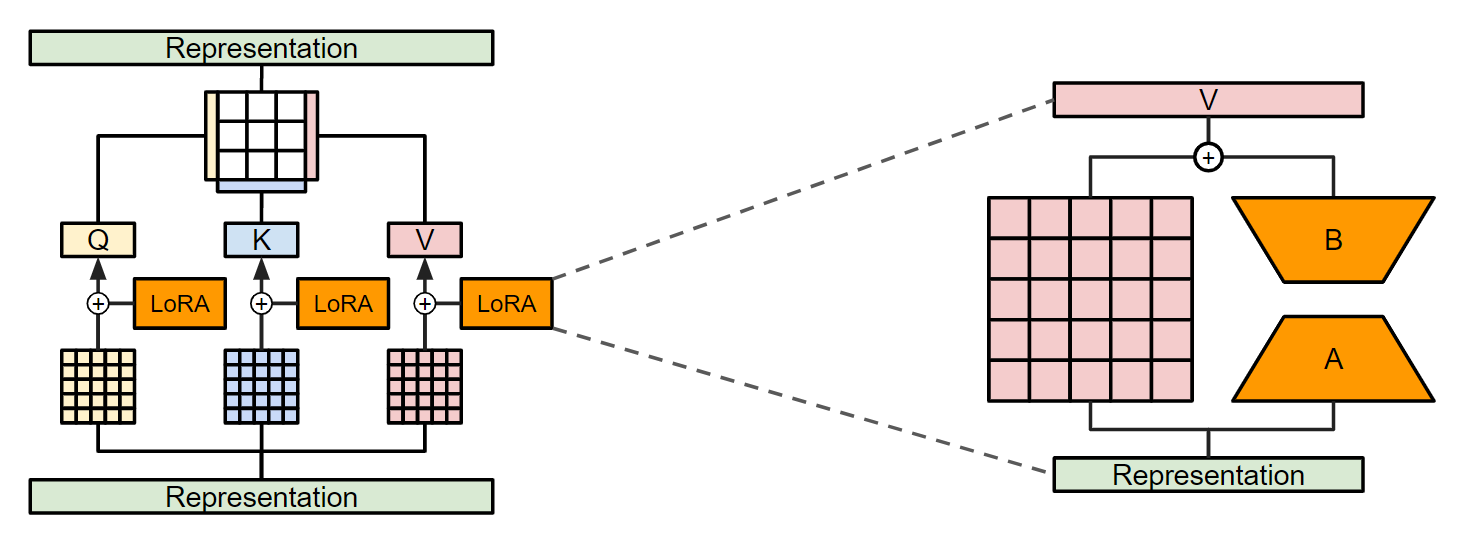

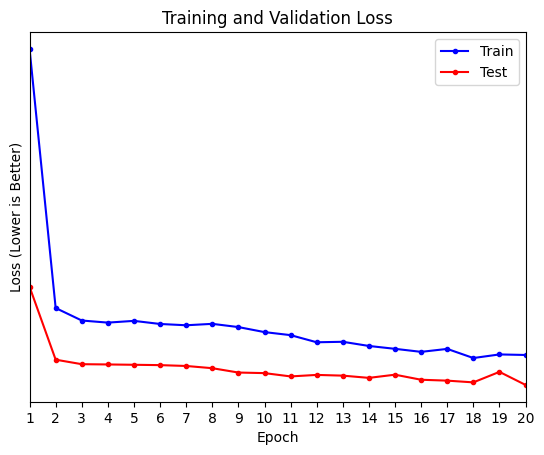

Training complete.


In [ ]:
%matplotlib inline
#@markdown We can directly run training using the same code as before, now that we have added LoRA adaptors to our model!
learning_rate = 1e-3 # @param {"type":"number"}
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20  # @param {"type":"integer"}
train_model(model, dataloaders[0], dataloaders[1], num_epochs, optimizer)


In [ ]:
#@markdown <font color='#e59454'>Question Time! Run to Show Question
import random
from IPython.display import display, HTML

def create_quiz(question, correct_answer, decoy_answers):
    answers = [correct_answer] + decoy_answers
    random.shuffle(answers)

    html_code = f"""
    <div style="font-family: Arial, sans-serif; margin: 30px; max-width: 1000px;">
      <h3 style="word-wrap: break-word;">{question}</h3>
    """

    for i, answer in enumerate(answers):
        html_code += f"""
        <div style="word-wrap: break-word; margin-bottom: 10px;">
          <input type="radio" id="option{i}" name="quiz" value="{answer}">
          <label for="option{i}" id="label{i}">{answer}</label>
        </div>
        """

    html_code += f"""
      <button onclick="checkAnswer()">Submit</button>
      <p id="feedback" style="font-weight: bold;"></p>
    </div>
    <script>
    function checkAnswer() {{
        var radios = document.getElementsByName('quiz');
        var correctAnswer = "{correct_answer}";
        var feedback = document.getElementById('feedback');
        var selectedOption = null;
        var selectedLabel = null;

        for (var i = 0, length = radios.length; i < length; i++) {{
            if (radios[i].checked) {{
                selectedOption = radios[i].value;
                selectedLabel = document.getElementById('label' + i);
                break;
            }}
        }}

        if (selectedOption) {{
            if (selectedOption === correctAnswer) {{
                feedback.textContent = "Correct!";
                feedback.style.color = "green";
                selectedLabel.style.color = "green";
            }} else {{
                feedback.textContent = "Incorrect.";
                feedback.style.color = "red";
                selectedLabel.style.color = "red";
            }}
        }} else {{
            feedback.textContent = "Please select an answer.";
            feedback.style.color = "orange";
        }}
    }}
    </script>
    """
    display(HTML(html_code))

question = "How does LoRA help in finetuning large language models?"
correct_answer = "It reduces the number of trainable parameters, allowing for efficient finetuning on smaller datasets and preventing overfitting."
decoy_answers = [
    "It increases the model's capacity by adding more layers.",
    "It completely replaces the original model architecture.",
    "It only trains on new data, ignoring the pre-trained weights."
]
create_quiz(question, correct_answer, decoy_answers)

We can change the **rank** and (optionally, **dropout**) to better tune our model. Specifically, editing the rank controls the degree to which we want to fine-tune our model. The adaptor restricts the range which the model parameters can change, and adjusting the rank will control this range.

**If the rank is too big**, we will effectively do the same thing as raw finetuning. **If it is too small**, the model will not be finetuned at all because the parameters can't change enough

Try playing around with different values and see how this affects the training!

In [ ]:
%matplotlib inline
# Reloading model so that we don't have to re-run
model = EsmForTokenClassification.from_pretrained(f"facebook/{model_name}",
                                                  num_labels=1,
                                                  hidden_dropout_prob=0.15)

tokenizer = AutoTokenizer.from_pretrained(f"facebook/{model_name}")
model = model.to(DEVICE)

#@markdown Change rank and dropout
rank = 4 # @param {"type":"integer"}
dropout = 0.15 # @param {"type":"number"}

config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    target_modules=["query", "key", "value"],
    r=rank,
    lora_dropout=0.15,
)
model = get_peft_model(model, config)

#@markdown Training Parameters
learning_rate = 1e-3 # @param {"type":"number"}
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20  # @param {"type":"integer"}
train_model(model, dataloaders[0], dataloaders[1], num_epochs, optimizer)

## **<font color='#569098'>Conclusion**
In this notebook, we've explored how to finetune protein language models for specific tasks. We've learned about:
<font color='#e59454'>
1. The benefits of finetuning.
3. Finetuning techniques, with a focus on Low Rank Adaptation (LoRA).
4. Applying these concepts to a practical task: predicting ligand-binding sites.

By leveraging these powerful models and efficient finetuning techniques, we can push the boundaries of protein design and accelerate discoveries in fields like drug development and enzyme engineering.

For further exploration, consider:
- Experimenting with different model architectures and sizes, especially with structure-aware language models, such as SaProt!
- Adjusting LoRA sizes to find the best balance.
- Applying these models to other protein-related tasks, such as predicting protein-protein interactions or designing novel proteins with specific functions

Remember, the field of protein language models is rapidly evolving, so stay curious and keep learning!

# **<font color='#569098'>Section 4: Suggested reading**</font>

Relevant papers


* Low-N protein engineering with data-efficient deep learning, Biswas et al., Nature Methods, 2021
* Contrastive Fitness Learning: Reprogramming Protein Language Models for Low-N Learning of Protein Fitness Landscape, Zhao et al., bioRxiv, 2024
* Fine-tuning protein language models boosts predictions across diverse tasks, Schmirler et al., Nature Communications, 2024
* SeqProFT: Applying LoRA Finetuning for Sequence-only Protein Property Predictions, Zhang et al., arXiv, 2024